In [110]:
import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

In [2]:
from sklearn import datasets

In [3]:
df = datasets.load_digits()

In [4]:
df.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [330]:
X = df['data']

In [148]:
n_classes = len(df['target_names'])

In [331]:
X.shape

(1797, 64)

In [8]:
y = df['target']

In [9]:
y[:20]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [10]:
n_cases = len(y)
n_train = round(0.8 * n_cases)
n_test = n_cases - n_train

In [11]:
train_idx = np.random.choice(n_cases, n_train, replace=False)
train_idx_bin = np.array([False] * n_cases)
train_idx_bin[train_idx] = True

In [12]:
X_train = X[train_idx_bin,:]
X_test = X[~train_idx_bin,:]
y_train = y[train_idx_bin]
y_test = y[~train_idx_bin]

In [13]:
X_test.shape

(359, 64)

In [14]:
y_train.shape

(1438,)

# Show some training data

In [15]:
images_train = df['images'][train_idx_bin,:]
print(images_train.shape)

images_test = df['images'][~train_idx_bin,:]
print(images_test.shape)

(1438, 8, 8)
(359, 8, 8)


Labels: [0, 1, 2, 4]


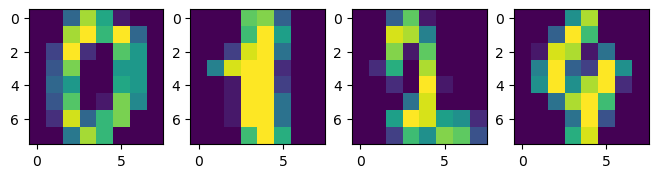

In [137]:
sample_idx = [0, 1, 10, 100]
sample_imgs = images_train[sample_idx]

def plot_imgs(imgs):
    """ Plot the given 2d images in a nice array"""
    max_width = 10
    n_imgs = len(imgs)

    width = min(max_width, n_imgs)
    height = n_imgs // 10 + 1
    
    fig = plt.figure(figsize=(2*n_imgs, 10))
    for idx in range(n_imgs):
        sp = fig.add_subplot(height, width, idx+1)
        sp.imshow(imgs[idx])
        
plot_imgs(sample_imgs)
        
print(f'Labels: {[y_train[idx] for idx in sample_idx]}')

# KNN Classifier

## Try out a couple of k's...

In [104]:
knn_values = [1, 3, 5, 7, 9]

In [106]:
acc_scores = []
for val in knn_values:
    knn = KNeighborsClassifier(n_neighbors=val)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acc_scores.append(acc)
    print(f'K={val}, acc={acc}')

K=1, acc=0.9860724233983287
K=3, acc=0.9944289693593314
K=5, acc=0.9888579387186629
K=7, acc=0.9805013927576601
K=9, acc=0.9860724233983287


Text(0, 0.5, 'Accuracy for test set')

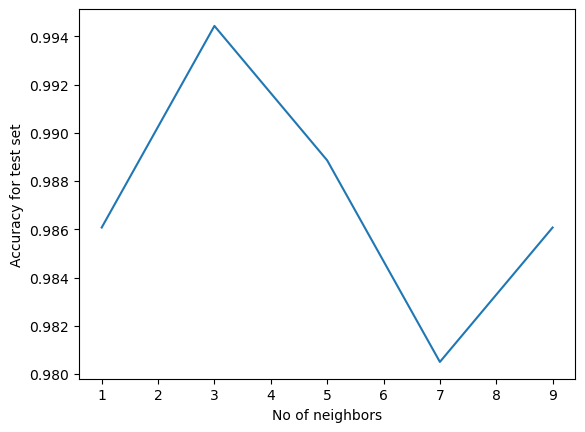

In [108]:
plt.plot(knn_values, acc_scores);
plt.xlabel("No of neighbors")
plt.ylabel("Accuracy for test set")

In [96]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [97]:
y_pred = knn.predict(X_test)

In [98]:
accuracy_score(y_test, y_pred)

0.9944289693593314

[[32  0  0  0  0  0  0  0  0  0]
 [ 0 41  0  0  0  0  0  0  0  0]
 [ 0  0 31  0  0  0  0  0  0  0]
 [ 0  0  0 35  0  0  0  0  0  0]
 [ 0  0  0  0 39  0  0  0  0  0]
 [ 0  0  0  0  0 39  0  0  0  0]
 [ 0  0  0  0  0  0 33  0  0  0]
 [ 0  0  0  0  0  0  0 34  0  0]
 [ 0  1  0  0  0  0  0  0 38  0]
 [ 0  0  0  1  0  0  0  0  0 35]]


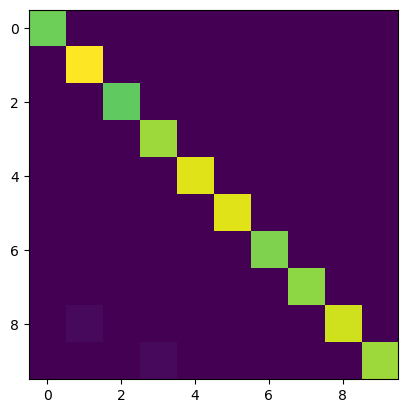

In [99]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.imshow(cm);

# Analyse misclassified cases

In [100]:
misclass_idx = y_test != y_pred

X_mis = X_test[misclass_idx]
y_mis = y_pred[misclass_idx]
y_true = y_test[misclass_idx]
img_mis = images_test[misclass_idx]

In [101]:
X_mis.shape

(2, 64)

Pred labels: [1 3]
True labels: [8 9]


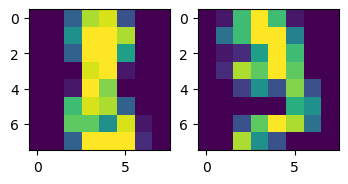

In [102]:
plot_imgs(img_mis)

print(f'Pred labels: {y_mis}')
print(f'True labels: {y_true}')

# Look at their neighbors

Verdict: [1]
Verdict: [3]


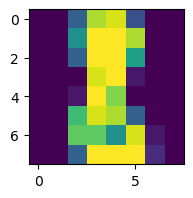

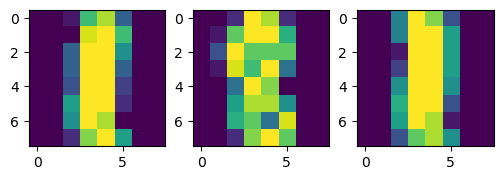

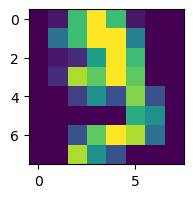

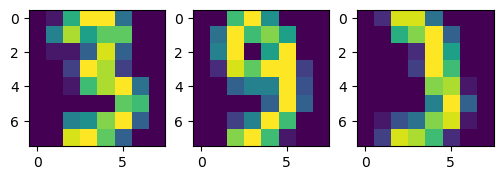

In [103]:
def compare_to_neighbors(X, knn_model):
    neighbors = knn_model.kneighbors(X.reshape(1, -1))
    y_pred = knn_model.predict(X.reshape(1, -1))
    neighbors_idx = neighbors[1][0]
    n_neighbors = knn_model.n_neighbors
    neighbor_images = X_train[neighbors_idx,:].reshape(n_neighbors, 8, -1)
    print(f"Verdict: {y_pred}")
    plot_imgs(X.reshape(1, 8, -1))
    plot_imgs(neighbor_images)
    
for X_point in X_mis:
    compare_to_neighbors(X_point, knn)

# Something silly - Naive Bayes...

In [112]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

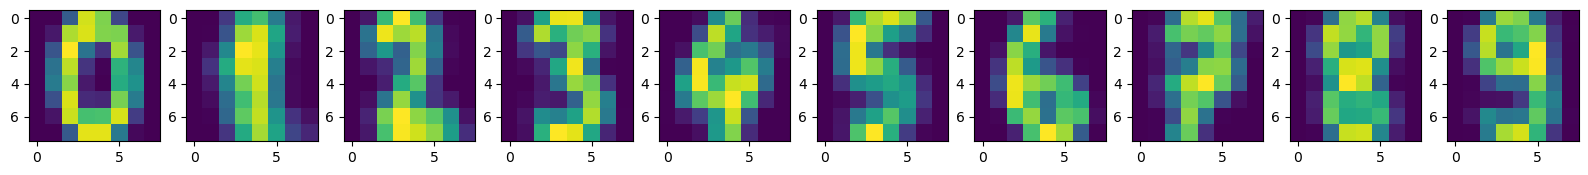

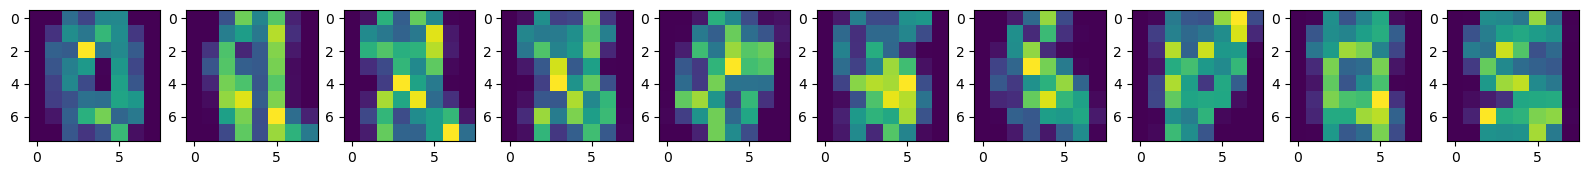

In [151]:
# analyze the estimated means of features per class
plot_imgs(gnb.theta_.reshape(n_classes, 8, -1))
# and the vars...
plot_imgs(gnb.var_.reshape(n_classes, 8, -1))

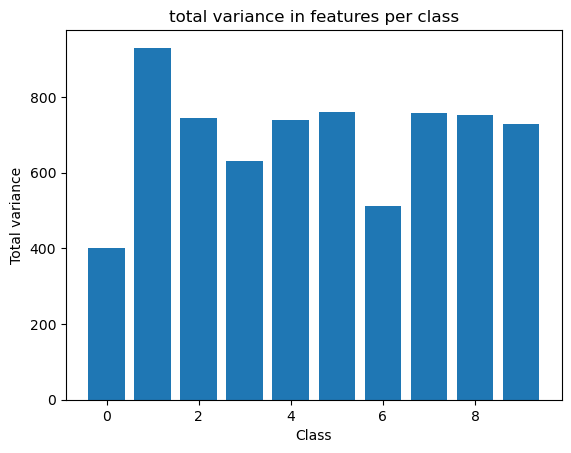

In [164]:
sum_var = np.sum(gnb.var_, axis=1)
plt.bar(np.arange(n_classes), sum_var);
plt.xlabel("Class");
plt.ylabel("Total variance");
plt.title("total variance in features per class");

In [114]:
y_pred = gnb.predict(X_test)

0.8523676880222841


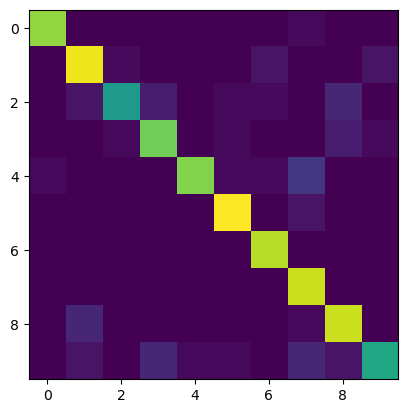

In [117]:
print(accuracy_score(y_test, y_pred))
plt.imshow(confusion_matrix(y_test, y_pred))

Actual label: [2 8 9]
Pred label: [5 1 7]
[[0.00000000e+000 6.96692634e-229 2.31065462e-001 4.33779953e-014
  0.00000000e+000 7.10655992e-001 0.00000000e+000 0.00000000e+000
  5.82785462e-002 3.44170902e-050]
 [0.00000000e+000 7.65103071e-001 4.99484915e-019 1.09542038e-011
  1.23001931e-023 6.58800860e-033 7.25690036e-090 0.00000000e+000
  2.34896929e-001 1.45499649e-035]
 [0.00000000e+000 2.59188639e-023 1.58559281e-028 1.81756148e-015
  1.37049293e-029 9.68072117e-065 0.00000000e+000 9.99857860e-001
  1.42139727e-004 2.24255842e-011]]


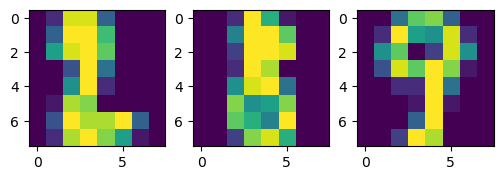

In [276]:
# what are the misclassified X's like
idx_from, idx_to = 5, 8

miscl_idx = y_pred != y_test
X_miscl = X_test[miscl_idx][idx_from:idx_to]
n_cases = X_miscl.shape[0]
plot_imgs(X_miscl.reshape(n_cases, 8, -1))
print(f"Actual label: {y_test[miscl_idx][idx_from:idx_to]}")
print(f"Pred label: {y_pred[miscl_idx][idx_from:idx_to]}")
y_probs = gnb.predict_proba(X_miscl)
print(y_probs)


# Logistic regression

In [290]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

logr = LogisticRegression()
logr.fit(X_train_scaled, y_train)

LogisticRegression()

In [291]:
y_pred = logr.predict(X_test)

0.7493036211699164


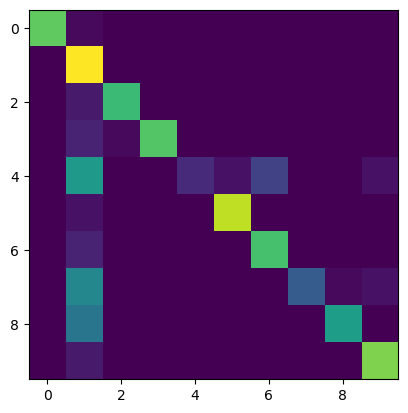

In [292]:
print(accuracy_score(y_test, y_pred))
plt.imshow(confusion_matrix(y_test, y_pred));

# Try drawing...

## Stack Oveflow code below

In [244]:
my_images = []

In [304]:
from PIL import ImageTk, Image, ImageDraw
import PIL
from tkinter import *
from skimage.transform import resize

width = 160  # canvas width
height = 160 # canvas height
center = height//2
white = (255, 255, 255) # canvas back

def save():
    # save image to hard drive
    np_array = np.array(output_image.getdata()).reshape(width, height, -1)
    img_corrected = 255 - np_array[:,:,0]
    img_resized = resize(img_corrected, (8, 8), preserve_range=True)
    my_images.append(img_resized)
    
def predict():
    np_array = np.array(output_image.getdata()).reshape(width, height, -1)
    img_corrected = 255 - np_array[:,:,0]
    img_resized = resize(img_corrected, (8, 8), preserve_range=True)
    
    drawn_image = (img_resized / np.max(img_resized)) * 16

    print(knn.predict(drawn_image.reshape(1, -1)))
    print(gnb.predict(drawn_image.reshape(1, -1)))
    print(logr.predict(drawn_image.reshape(1, -1)))

def paint(event):
    x1, y1 = (event.x - 1), (event.y - 1)
    x2, y2 = (event.x + 1), (event.y + 1)
    canvas.create_oval(x1, y1, x2, y2, fill="black",width=25)
    draw.line([x1, y1, x2, y2],fill="black",width=25)
    
def clearc():
    canvas.create_rectangle((0, 0, width, height), fill="white")
    draw.rectangle((0, 0, width, height), fill="white")
    draw.line([0, 0, 50, 50],fill="black",width=25)

master = Tk()

# create a tkinter canvas to draw on
canvas = Canvas(master, width=width, height=height, bg='white')
canvas.pack()

# create an empty PIL image and draw object to draw on
output_image = PIL.Image.new("RGB", (width, height), white)
draw = ImageDraw.Draw(output_image)
canvas.pack(expand=YES, fill=BOTH)
canvas.bind("<B1-Motion>", paint)

# classify button
button2=Button(text="classify",command=predict)
button2.pack()
# clear button
button3=Button(text="clear",command=clearc)
button3.pack()

master.mainloop()

[1]
[1]
[1]
[2]
[8]
[1]
[1]
[8]
[1]
[1]
[8]
[1]
[9]
[8]
[9]
[4]
[2]
[4]


# Feed the image to the models:

[0]
[4]
[0]


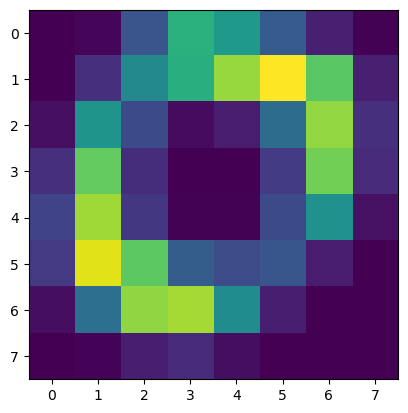

In [294]:
drawn_image = (my_images[-1] / np.max(my_images[-1])) * 16

plt.imshow(drawn_image)

print(knn.predict(drawn_image.reshape(1, -1)))
print(gnb.predict(drawn_image.reshape(1, -1)))
print(logr.predict(drawn_image.reshape(1, -1)))

# Try reducing the dimensionality just for fun (PCA, T-SNE)

In [318]:
from matplotlib import colormaps
list(colormaps)

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viridis_r',
 'cividis_r',
 'twilight_r',
 'twilight

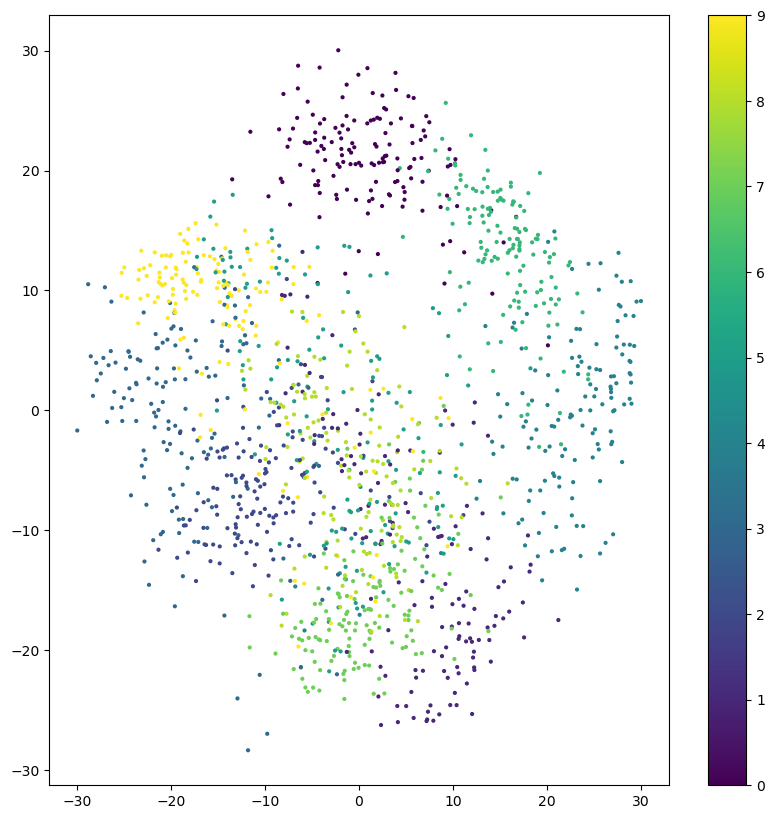

In [316]:
pca = PCA(n_components=2)
X_t = pca.fit_transform(X_train)

plt.figure(figsize=(10, 10))
plt.scatter(X_t[:,0], X_t[:,1], s=4, c=y_train)
plt.colorbar()

In [321]:
tsne = TSNE(n_components=2)
X_t = tsne.fit_transform(X_train)

In [327]:
tsne.perplexity

30.0

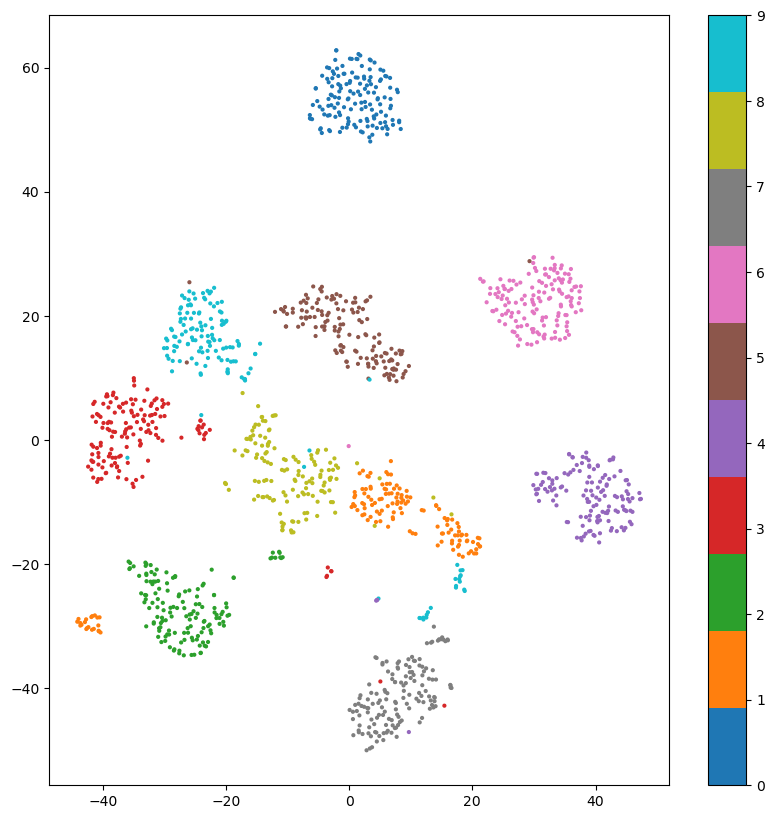

In [322]:
plt.figure(figsize=(10, 10))
plt.scatter(X_t[:,0], X_t[:,1], s=4, c=y_train, cmap=colormaps['tab10'])
plt.colorbar()

In [326]:
knn_tsne = KNeighborsClassifier(n_neighbors=5).fit(X_t, y_train)
X_test_tsne = tsne
y_pred = knn_tsne.predict() # huh...

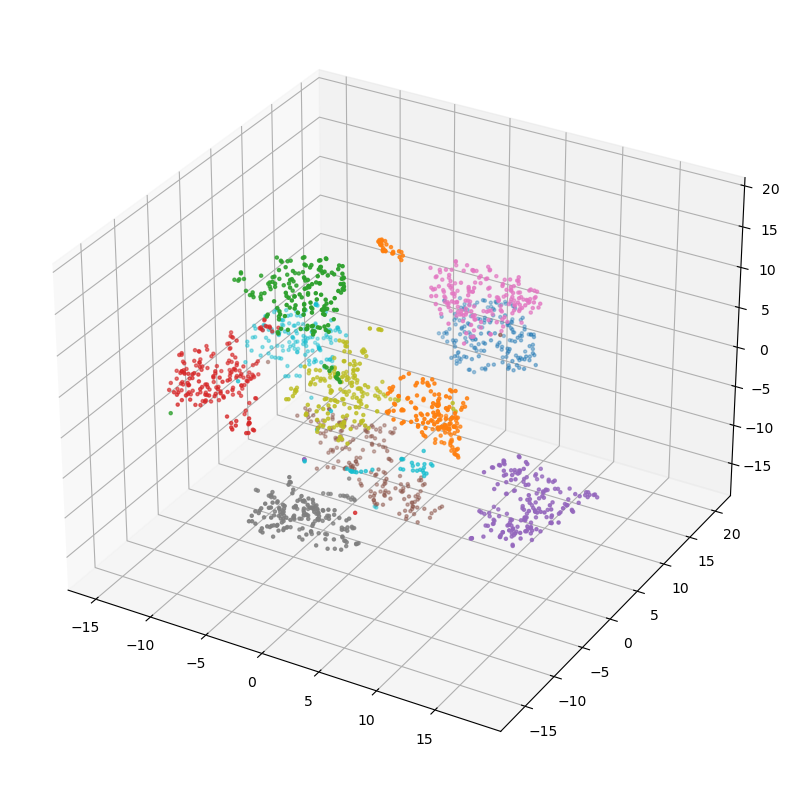

In [335]:
# tsne3d = TSNE(n_components=3)
# X_t3d = tsne3d.fit_transform(X)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
 
ax.scatter(X_t3d[:,0], X_t3d[:,1], X_t3d[:,2], marker='.', c=y, cmap=colormaps['tab10']);

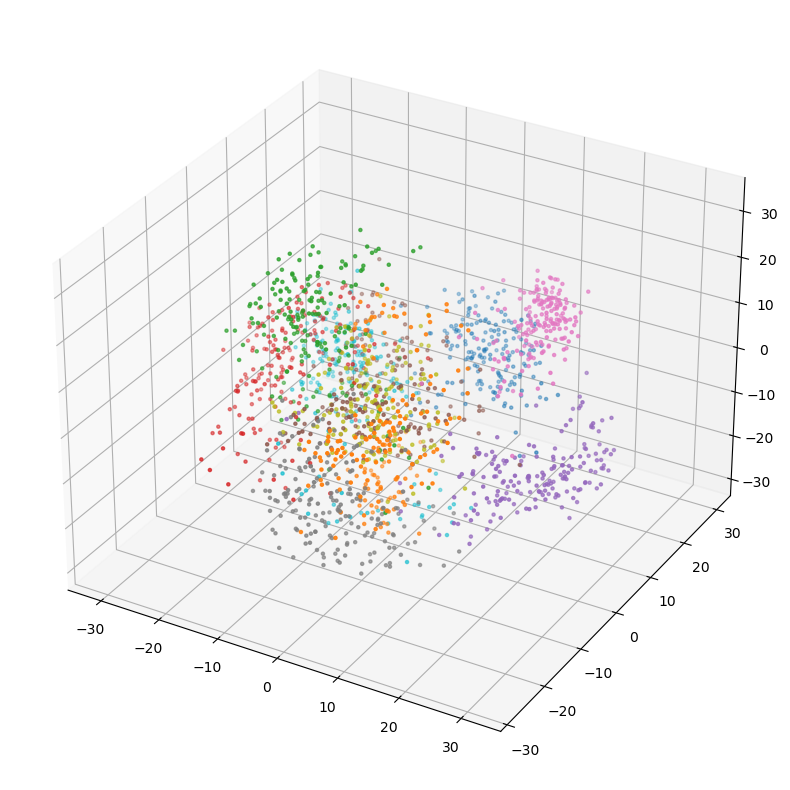

In [336]:
pca3d = PCA(n_components=3)
X_t3d = pca3d.fit_transform(X)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
 
ax.scatter(X_t3d[:,0], X_t3d[:,1], X_t3d[:,2], marker='.', c=y, cmap=colormaps['tab10']);

### TODO
* Compare training time, prediction time and memory usage for the three models (+NN)
* Find a better GUI, preferably embedded in the NB